In [2]:
from convokit import Corpus, User, Utterance
import json
from collections import Counter

In [1]:
#you may need this:#
!pip install spacy

     |████████████████████████████████| 30.9MB 9.3kB/s eta 0:00:01   |                                | 81kB 2.4MB/s eta 0:00:14     |███████████████████▉            | 19.1MB 2.3MB/s eta 0:00:06��█████   | 27.9MB 305kB/s eta 0:00:10��██████████████████████████▊ | 29.6MB 305kB/s eta 0:00:04
     |████████████████████████████████| 3.2MB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 4.3MB/s eta 0:00:01     |█████████████████▏              | 1.1MB 4.3MB/s eta 0:00:01
     |████████████████████████████████| 184kB 9.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 7.9MB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
#And this#
!python -m spacy download en

In [75]:
#One more#
!pip install nltk

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
input_files = ['friends_season_01.json',
                  'friends_season_02.json',
                  'friends_season_03.json',
                  'friends_season_04.json',
                  'friends_season_05.json',
                  'friends_season_06.json',
                  'friends_season_07.json',
                  'friends_season_08.json',
                  'friends_season_09.json',
                  'friends_season_10.json']

In [4]:
#for the purposes of the notebook, here's a means of dowloading the corpus virtually.#
import requests
import json

# read the JSON file from the web
for file in input_files:
    link = 'https://raw.githubusercontent.com/emorynlp/character-mining/master/json/' + file
    r = requests.get(link)

#loading as seasons#
season = json.loads(r.text)

**USER CORPUS**
Developing a robust user corpus is a priority of my project given its focus on characterization. Knowing this, I spent the bulk of my working generating a few additional types of metadata to include with each user. Another priority of the code is to retain season-level information within the grander context of the series as a whole.

In future versions of this dataset, I would be interested in including episode-level and scene-level information about users. In terms of sourcing outside metadata, I think that Gender metadata could be sourced from crosslisting character names with IMDB.

Below, I offer an example of the current pipeline to give an overview of the conversion process. This pipeline  Since two definitions have not been defined yet, it is unfunctional as is.

In [5]:
character_distribution = []
for name in input_files:
    with open(name) as data:
        season = json.load(data)
        season_id = season['season_id']
        episodes = season['episodes']
        character_distribution.append([season_id,season_speaking_users(episodes)])
character_matrix = series_speaking_users(character_distribution)

FileNotFoundError: [Errno 2] No such file or directory: 'friends_season_01.json'

The pipeline above stresses the production of a season-level _character distribution_ and a series-level _character matrix_. I divide the dataset as such in order to better account for the distribution of user dialogue and reference across different scales of narrative. The function **season_speaking_users** works to divide and count users into two main roles, speakers and figures of reference, and assign the quality of being a nonspeaker, a nonspeaking user who is referenced. Nonspeaking users fascinatingly are typically either famous guest stars (like Ed Begley Jr.) or entirely generic onscreen figures, like a silent airplane steward.

While seasons one through four feature an additional category called "character_entities" that refers to the characters mentioned in or around the conversation, this convention is dropped from season five on. That is, it's not possible using the current dataset to track nonspeaking users throughout the duration of the season. I do believe, however, it would be worthwhile to see if: 1.)nonspeaking characters reccur or become a type of trope (Are there silent characters who show up on screen and shrug for laugh? Is it usually poorly-disguised celebrities who fill these roles to produce a sight gag?) 2.)If the characaters who are referenced by main characters in earlier seasons end up getting more speaking roles as the series progresses.

In [6]:
def season_speaking_users(episodes):
    ssu = []
    sru = []
    for id in range(len(episodes)):
        episode = episodes[id]
        scenes = episode['scenes']
        for scene in scenes:
            for place in range(len((scene['utterances']))):
                utterance = scene['utterances'][place]
                speakers = utterance['speakers']
                ##1.) See markup below##
                if len(speakers) >= 1:
                    for p in range(len(speakers)):
                        ssu.append(speakers[p])
                if 'character_entities' in utterance:
                    character_entities = utterance['character_entities']
                    for place in range(len(character_entities)):
                        if len(character_entities[place]) >1:
                            character_range = character_entities[place]
                            for position in range(len(character_range)):
                                sru.append(character_range[position][2])
                
                
    ##counting##
    season_speaking_users = Counter(ssu)
    season_referenced_users = Counter(sru)
    season_non_speaking_users = []
    
    ##finding non-speaking users##
    for key in [i for i in season_referenced_users]:
        if key in [i for i in season_speaking_users]: 
            pass
        else:
            season_non_speaking_users.append(key)
    return [season_speaking_users, season_referenced_users, season_non_speaking_users]


The code above uses counters to measure the number of utterance and references each character makes. It also features a small amount of code to discover nonspeaking users. Ultimately, the code produces two dictionaries that take the names of characters for keys and return the number of utterances and references that respectively occur within the season. It also returns a list of nonspeaking users.

1.) One of the larger peculiarities of the dataset was instances where characters would talk in unison. I'm not sure if there's a good way to parse this - should the collective be treated as a single user? - though it would be interesting to see if there are certain combinations that happen frequently throughout the seasons.

In [7]:
def series_speaking_users(character_distribution):
   
    ## 1.##
    all_characters =[]
    for season in character_distribution:
        speakers = season[1][0]
        referees = season[1][1]
        nonspeakers = season[1][2]
        for speaker in speakers:
            if speaker not in all_characters:
                all_characters.append(speaker)
        for referee in referees:
            if referee not in all_characters:
                all_characters.append(referee)
        for ns in nonspeakers:
            if ns not in all_characters:
                    all_characters.append(ns)
    ## 2. ##                
    characters_tagged = dict()
    for character in all_characters:
        total_spoken = 0
        season_spoken = []
        total_referenced = 0
        season_referenced = []
        for season in character_distribution:
            speakers = season[1][0]
            referees = season[1][1]
            season_id = season[0]
            total_spoken += speakers[character]
            season_spoken.append([season_id , speakers[character]])
            total_referenced += referees[character]
            season_referenced.append([season_id, referees[character]])
        characters_tagged[character] = [total_spoken, season_spoken, total_referenced, season_referenced]
    return characters_tagged

1.) In order to collect series-level statistics from the season-level this function's first half collects the names of all users across the two qualities and nonspeaking condition.

2.) That list is then fed into and combined with the season-level dictionaries created by the previous function. Two **total** qualities track all of the utterances and references that occur for a user within the series, while season_spoken and season_reference return each season and its counts. Part of the intuition for this approach is to see how much a character's share and quantity of dialogue changes through the course of several seasons.

In [8]:
character_distribution = []
for file in input_files:
    link = 'https://raw.githubusercontent.com/emorynlp/character-mining/master/json/' + file
    r = requests.get(link)
    season = json.loads(r.text)
    season_id = season['season_id']
    episodes = season['episodes']
    character_distribution.append([season_id,season_speaking_users(episodes)])
character_matrix = series_speaking_users(character_distribution)

Let's see an example of how the character_matrix works!

In [9]:
character_matrix['Rachel Green']

[9417,
 [['s01', 865],
  ['s02', 819],
  ['s03', 936],
  ['s04', 980],
  ['s05', 921],
  ['s06', 1002],
  ['s07', 1107],
  ['s08', 1089],
  ['s09', 913],
  ['s10', 785]],
 4068,
 [['s01', 905],
  ['s02', 982],
  ['s03', 1096],
  ['s04', 1085],
  ['s05', 0],
  ['s06', 0],
  ['s07', 0],
  ['s08', 0],
  ['s09', 0],
  ['s10', 0]]]

In [10]:
user_meta = {}
for user in character_matrix.keys():
    user_meta[user] =   {"character_name": character_matrix[user],
                               "total_utterances": character_matrix[user][0],
                               "utterances_per_season": character_matrix[user][1],
                               "total_references": character_matrix[user][2],
                               "references_per_season": character_matrix[user][3]}
                

##making Corpus##
corpus_users = {k: User(name = k, meta = v) for k,v in user_meta.items()}

In this version of the User Corpus, each user ends up with five characteristics. I intend to use the proportions of these characteristics to determine what role utterance and reference quantity play in separating major and minor characters across seasons.

In terms of adding future metadata, I would be interested in seeing the average-sized converation each character participate in per season and the average size of the groups those conversations take place in. When thinking about major and minor characters, it would be curious to see if speaking-but-not-major characters tend to be relegated to certain group sizes or shorter conversational instances.

What I'd love most in terms of metadata, however, was a way to parse the "transcript with note" subcategory in each utterance for character information/set directions. It would be fascinating to see which physical behaviors and details get assigned to which character.

**UTTERANCE CORPUS**
Given my project's interest in users, I've made significantly fewer modifications in generating metadata for the utterance corpus. Nevertheless, I believe that in future iterations of this code, the utterance corpus will make some of the user-processing accomodations I made above redundant. So it goes with version 1!



In [11]:
utterance_corpus = {}
for file in input_files:
    link = 'https://raw.githubusercontent.com/emorynlp/character-mining/master/json/' + file
    r = requests.get(link)
    season = json.loads(r.text)
    season_id = season['season_id']
    episodes = season['episodes']
    #############################
    for id in range(len(episodes)):
        episode = episodes[id]
        scenes = episode['scenes']
        for scene in scenes:
            for place in range(len((scene['utterances']))):
                utterance = scene['utterances'][place]
                id = utterance['utterance_id']

                ##1.)Some utterances involve multiple speakers stored as a list. This process treats them individually, though it is worth##
                ##contesting whether two characters speaking in unison is a singular utterance##
                if len(utterance["speakers"]) >= 1:
                    for p in range(len(utterance["speakers"])):
                        user = User(utterance["speakers"][p])

                ##2.)Getting the root is relatively easy given how organized the dataset is already. This code replaces the ending of scenes##
                ##with the first utterance of the scene##
                part = id.split('_')[:3]
                part.append('u001')
                root = '_'.join(part)

                ##3.)There is a 'character_entities' subsection of each utterance that features all characters involved and or referenced.##
                ##Designating a reply from this data is theoretically more accurate than going to the previous utterance, but not all seasons##
                ##contain this metadata##
                if id.split('_')[3] == "u001":
                    reply_to = None
                else:
                    prior = scene['utterances'][place - 1]['speakers']
                    if len(prior) >= 1:
                        for p in range(len(prior)):
                            reply_to = prior[p]
                    else:
                        reply_to = None
                timestamp = None

                ##there's a tokenized version available in the data set too##
                text = utterance["transcript"]
                utterance_corpus[id] = Utterance(id, user, root, reply_to, timestamp, text)

To expand on the comments above:

2.) In thinking more about the qualities of syndicated televison, many scenes and conversations begin in medias res or correspond to a cliffhanger from before the commercial break. I can't think of a better to determine where a conversation starts, but I do think it's important to measure the composition and similarity of conversations across scenes.

3.) In measuring replies, the code-as-is assumes that the current utterance is responding to the one immediately before it. Honestly, I don't feel super comfortable with this assumption. For one, _Friends_ is known for having at least one two characters who introduce nonsequitirs into conversation. **A distinction should be made between if being a part of a scene and being a part of a conversation are the same thing, especially in a comedy**. I would be interested to see how well the character_entities data corresponds to assuming conversationality in a linear representation of a scene.

In [12]:
utterance_list = [utterance for k,utterance in utterance_corpus.items()]

In [13]:
series_corpus = Corpus(utterances=utterance_list, version=1)

In [14]:
convo_ids = series_corpus.get_conversation_ids()

Above are the three bits of code from the tutorial. Since not much worthwhile, additional metadata exits to add to this corpus, I have forgone it. If I was able to link IMDB to characters, however, I would also be able to get average ratings for each episode. This coudl be interesting in seeing if there's a generally positive response to certain cohorts of users.

In [15]:
print("number of conversations in the dataset = {}".format(len(series_corpus.get_conversation_ids())))

number of conversations in the dataset = 3107


In [17]:
series_corpus.dump("friends_corpus", base_path= "./")

In [36]:
series_corpus.print_summary_stats()

Number of Users: 699
Number of Utterances: 67373
Number of Conversations: 3107


**Transformations and Parsing**

This section involves parsing conversations in the series corpus. It takes quite a long time.

In [16]:
from convokit import Parser

In [18]:
annotator = Parser()

In [19]:
series_corpus = annotator.fit_transform(series_corpus)

**Dalliances with Politeness**

In this section, I explore a few ways that politeness could be correlated with a character's longevity in the show.  Another way of framing this is do characters who have similar compositions of impolite|polite conversation to major characters have a higher likelihood of remaining on the show?

In [ ]:
#this might be necessary#
import nltk
nltk.download('punkt')

In [ ]:
#this certainly is necessary#
from convokit import PolitenessStrategies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [20]:
ps = PolitenessStrategies(verbose=100)

In [76]:
politeness_corpus = ps.transform(series_corpus)

Preprocessing comments...
	100
	200
	300
	400
	500
	600
	700
	800
	900
	1000
	1100
	1200
	1300
	1400
	1500
	1600
	1700
	1800
	1900
	2000
	2100
	2200
	2300
	2400
	2500
	2600
	2700
	2800
	2900
	3000
	3100
	3200
	3300
	3400
	3500
	3600
	3700
	3800
	3900
	4000
	4100
	4200
	4300
	4400
	4500
	4600
	4700
	4800
	4900
	5000
	5100
	5200
	5300
	5400
	5500
	5600
	5700
	5800
	5900
	6000
	6100
	6200
	6300
	6400
	6500
	6600
	6700
	6800
	6900
	7000
	7100
	7200
	7300
	7400
	7500
	7600
	7700
	7800
	7900
	8000
	8100
	8200
	8300
	8400
	8500
	8600
	8700
	8800
	8900
	9000
	9100
	9200
	9300
	9400
	9500
	9600
	9700
	9800
	9900
	10000
	10100
	10200
	10300
	10400
	10500
	10600
	10700
	10800
	10900
	11000
	11100
	11200
	11300
	11400
	11500
	11600
	11700
	11800
	11900
	12000
	12100
	12200
	12300
	12400
	12500
	12600
	12700
	12800
	12900
	13000
	13100
	13200
	13300
	13400
	13500
	13600
	13700
	13800
	13900
	14000
	14100
	14200
	14300
	14400
	14500
	14600
	14700
	14800
	14900
	15000
	15100
	15200
	15300
	15400
	155

In [77]:
utterance_ids = politeness_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    rows.append(politeness_corpus.get_utterance(uid).meta["politeness_strategies"])
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)
politeness_strategies.head(10)

,feature_politeness_==1st_person==,feature_politeness_==1st_person_pl.==,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Apologizing==,feature_politeness_==Deference==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==Factuality==,...,feature_politeness_==HASHEDGE==,feature_politeness_==HASNEGATIVE==,feature_politeness_==HASPOSITIVE==,feature_politeness_==Hedges==,feature_politeness_==INDICATIVE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==SUBJUNCTIVE==
s01_e01_c01_u001,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
s01_e01_c01_u002,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
s01_e01_c01_u003,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
s01_e01_c01_u004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s01_e01_c01_u005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s01_e01_c01_u006,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s01_e01_c01_u007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s01_e01_c01_u008,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
s01_e01_c01_u009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
s01_e01_c01_u010,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Politeness Vector**

As you can see above, there are many utterances and many different types of politeness. It's worth theorizing which of these qualities is most important for increasingly the likelihood of of a returning character. First, however, it's important to look at whether there are noticable differences between all character speech patterns by treating politeness as a vector.

In [78]:
characters = politeness_corpus.get_usernames()

#treating politeness as vector#
politeness_speech_patterns = []
for character in characters:
    user1 = series_corpus.get_user(character)
    utterances = user1.get_utterance_ids()
    rows = []
    for uid in utterances:
        rows.append(list(corpus.get_utterance(uid).meta["politeness_strategies"].values()))
    res = np.sum(rows, 0)
    res = [i/len(rows) for i in res]
    politeness_speech_patterns.append([character, res])

In [79]:
#maths#
def norm(vector):
    return sum([i**2 for i in vector]) ** .5

def dot_prod(vector1, vector2):
    total = 0
    for i in range(len(vector1)):
        total += vector1[i] * vector2[i]
    return(total)

def cos_sim(matrix):
    cos_sim_matrix = []
    for v1 in matrix:
        cos_sim_vec =[]
        for v2 in matrix:
            cos_sim = dot_prod(v1, v2)/(norm(v1) * norm(v2))
            cos_sim = ("%.3f" % cos_sim)
            cos_sim_vec.append(float(cos_sim))
        cos_sim_matrix.append(cos_sim_vec)
    return(cos_sim_matrix)

In [81]:
politeness_speech_matrix = [i[1] for i in politeness_speech_patterns]

In [94]:
print(politeness_speech_patterns[:10])

[['A Disembodied Voice', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], ['Gunther', [0.0, 0.0, 0.0, 0.04375, 0.01875, 0.0125, 0.0125, 0.01875, 0.04375, 0.1625, 0.13125, 0.26875, 0.0875, 0.025, 0.05625, 0.06875, 0.0, 0.0, 0.075, 0.14375, 0.075]], ['Ursula Buffay', [0.0, 0.0, 0.0, 0.05263157894736842, 0.05263157894736842, 0.0, 0.03508771929824561, 0.0, 0.07017543859649122, 0.3157894736842105, 0.05263157894736842, 0.17543859649122806, 0.03508771929824561, 0.05263157894736842, 0.07017543859649122, 0.05263157894736842, 0.0, 0.0, 0.07017543859649122, 0.3333333333333333, 0.17543859649122806]], ['Liam', [0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.0, 0.2222222222222222, 0.2222222222222222, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.1111111111111111]], ['Jake', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.16666666666666666, 0.166666666

In [82]:
cos_politeness_speech_matrix = cos_sim(politeness_speech_matrix)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in double_scalars



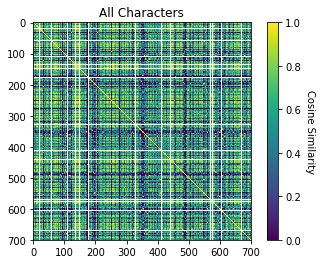

<Figure size 5400x4800 with 0 Axes>

In [96]:
#plotting#
psm_array = np.array(cos_politeness_speech_matrix)

fig, ax = plt.subplots()
im = ax.imshow(psm_array)

cbarlabel = "Cosine Similarity"
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

        
ax.set_title("All Characters")
fig=plt.figure(figsize=(18, 16), dpi= 300, facecolor='w', edgecolor='k')
plt.show()

This graph isn't very helpful. Let's try reordering characters in order of number of utterances.

In [116]:
characters = politeness_corpus.get_usernames()
char_uter = []
for character in characters:
    user1 = series_corpus.get_user(character)
    utterances = user1.get_utterance_ids()
    series_spoken = len(utterances)
    char_uter.append([character, series_spoken])
char_uter[0]
    
char_uter_most = sorted(char_uter, key=lambda x: x[1])
max_char = [i[0] for i in reversed(char_uter_most)]

In [131]:
max_politeness_speech_patterns = []
for character in max_char:
    user1 = series_corpus.get_user(character)
    utterances = user1.get_utterance_ids()
    rows = []
    for uid in utterances:
        rows.append(list(corpus.get_utterance(uid).meta["politeness_strategies"].values()))
    res = np.sum(rows, 0)
    res = [i/len(rows) for i in res]
    max_politeness_speech_patterns.append([character, res])

In [133]:
max_politeness_speech_matrix = [i[1] for i in max_politeness_speech_patterns]

In [134]:
max_cos_politeness_speech_matrix = cos_sim(max_politeness_speech_matrix)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in double_scalars



In [130]:
max_cos_politeness_speech_patterns

NameError: name 'max_cos_politeness_speech_patterns' is not defined

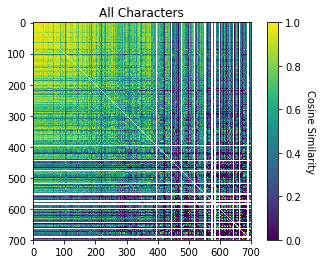

<Figure size 5400x4800 with 0 Axes>

In [136]:
labs = max_char
psm_array = np.array(max_cos_politeness_speech_matrix)

fig, ax = plt.subplots()
im = ax.imshow(psm_array)

cbarlabel = "Cosine Similarity"
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
        
ax.set_title("All Characters")
fig=plt.figure(figsize=(18, 16), dpi= 300, facecolor='w', edgecolor='k')
plt.show()

In [ ]:
ax.set_xticks(np.arange(len(labs)))
ax.set_yticks(np.arange(len(labs)))

In [51]:
recurring_characters = []
major_series_speaking_characters = []
major_season_speaking_characters = []
major_episode_speaking_characters = []
major_scene_speaking_characters = []


for character in characters:
    user1 = series_corpus.get_user(character)
    utterances = user1.get_utterance_ids()
    series_spoken = len(utterances)
    if series_spoken > 100:
        major_series_speaking_characters.append(character)
    season_spoken = []
    episode_spoken = []
    scene_spoken = []
    for utterance in utterances:
        u_split = utterance.split("_")
        season_spoken.append(u_split[0])
        episode_spoken.append("_".join(u_split[:1]))
        scene_spoken.append("_".join(u_split[:2]))
    season_sc = list(Counter(season_spoken).items())
    episode_sc = list(Counter(episode_spoken).items())
    scene_sc = list(Counter(scene_spoken).items())
    if len(season_sc) > 1:
        recurring_characters.append(character)
    for item in season_sc:
        if item[1] > 75:
            major_season_speaking_characters.append(character)
    for item in episode_sc:
        if item[1] > 25:
            major_episode_speaking_characters.append(character)
    for item in scene_sc:
        if item[1] > 7:
            major_scene_speaking_characters.append(character)
            
print("Total Characters:")
print(len(characters))
print("Characters who appear in more than 1 season")
print(len(recurring_characters))     
print("Characters who speak more than 100 times in the series:")
print(len(major_series_speaking_characters))
print("Characters who speak more than 75 times in any given season:")
print(len(set(major_series_speaking_characters)))
print("Characters who speak more than 25 times per episode:")
print(len(set(major_episode_speaking_characters)))
print("Characters who speak more than 7 times per scene:")
print(len(set(major_scene_speaking_characters)))

major_series_speaking_characters = list(set(major_series_speaking_characters))
major_season_speaking_characters = list(set(major_season_speaking_characters))
major_episode_speaking_characters = list(set(major_episode_speaking_characters))
major_scene_speaking_characters = list(set(major_scene_speaking_characters ))

Total Characters:
699
Characters who appear in more than 1 season
119
Characters who speak more than 100 times in the series:
27
Characters who speak more than 75 times in any given season:
27
Characters who speak more than 25 times per episode:
82
Characters who speak more than 7 times per scene:
258
